# Predicting house prices using k-nearest neighbors regression
In this notebook, I implemented k-nearest neighbors regression:
  * Find the k-nearest neighbors of a given query input
  * Predict the output for the query input using the k-nearest neighbors
  * Choose the best value of k using a validation set

# Fire up GraphLab Create

In [1]:
import graphlab


# Load in house sales data

A subset of the King County housing dataset created by randomly selecting 40% of the houses in the full dataset.

In [2]:
sales = graphlab.SFrame('kc_house_data_small.gl/')

GraphLab Create

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started

# Some important function

To efficiently compute pairwise distances among data points, we will convert the SFrame into a 2D Numpy array. First import the numpy library and then copy and paste `get_numpy_data()` from the second notebook of Week 2.

In [3]:
import numpy as np # note this allows us to refer to numpy as np instead

In [4]:
def get_numpy_data(data_sframe, features, output): # features and output are list here
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]

    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]

    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

We will also need the `normalize_features()` function from Week 5 that normalizes all feature columns to unit norm. Paste this function below.

In [5]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    normalized_features = feature_matrix / norms
    return (normalized_features, norms)

# Split data into training, test, and validation sets

In [6]:
(train_and_validation, test) = sales.random_split(.8, seed=1) # initial train/test split
(train, validation) = train_and_validation.random_split(.8, seed=1) # split training set into training and validation sets

# Extract features and normalize

Using all of the numerical inputs listed in `feature_list`, transform the training, test, and validation SFrames into Numpy arrays:

In [7]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']
features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')


In computing distances, it is crucial to normalize features. Otherwise, for example, the `sqft_living` feature (typically on the order of thousands) would exert a much larger influence on distance than the `bedrooms` feature (typically on the order of ones). We divide each column of the training feature matrix by its 2-norm, so that the transformed column has unit norm.

Norms of the features are stored in the training set. The features in the test and validation sets must be divided by these same norms, so that the training, test, and validation sets are normalized consistently.

In [8]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

# Compute a single distance

To start, let's just explore computing the "distance" between two given houses.  We will take our **query house** to be the first house of the test set and look at the distance between this house and the 10th house of the training set.



In [9]:
print features_test[0]

[ 0.01345102  0.01551285  0.01807473  0.01759212  0.00160518  0.017059    0.
  0.05102365  0.0116321   0.01564352  0.01362084  0.02481682  0.01350306
  0.          0.01345386 -0.01346927  0.01375926  0.0016225 ]


Now print the 10th row (index 9) of the training feature matrix. Again, you get an 18-dimensional vector with components between 0 and 1.

In [10]:
print features_train[9]

[ 0.01345102  0.01163464  0.00602491  0.0083488   0.00050756  0.01279425
  0.          0.          0.01938684  0.01390535  0.0096309   0.
  0.01302544  0.          0.01346821 -0.01346254  0.01195898  0.00156612]


In [11]:
d = features_test[0] - features_train[9]
dd = d**2
dd1 = np.sqrt(np.sum(dd))
print dd1

0.0597235937167


It is computationally inefficient to loop over computing distances to all houses in our training dataset. Fortunately, many of the Numpy functions can be **vectorized**.

A function that computes the distances from a query house to all training houses. The function should take two parameters: (i) the matrix of training features and (ii) the single feature vector associated with the query.

In [12]:
def ed(trng, vec):
    diff =trng[0:len(trng)] -  vec
    distances = np.sqrt(np.sum(diff**2, axis=1))
    return distances
    

*** QUIZ QUESTIONS ***

1.  Take the query house to be third house of the test set (`features_test[2]`).  What is the index of the house in the training set that is closest to this query house?
2.  What is the predicted value of the query house based on 1-nearest neighbor regression?

In [13]:
d = ed(features_train, features_test[2])
min_d = min(d)
index =d.argmin()
print min_d
print index

0.00286049526751
382


# Perform k-nearest neighbor regression

For k-nearest neighbors, we need to find a *set* of k houses in the training set closest to a given query house. We then make predictions based on these k nearest neighbors.

## Fetch k-nearest neighbors

Using the functions above, a function is written that takes in 
 * the value of k;
 * the feature matrix for the training houses; and
 * the feature vector of the query house
 
and returns the indices of the k closest training houses. For instance, with 2-nearest neighbor, a return value of [5, 10] would indicate that the 6th and 11th training houses are closest to the query house.



In [14]:
def knn(trnmat, qmat,k):
    #for u in xrange(0,len(qmat)):
    diff =trnmat[0:len(trnmat)] -  qmat
    distances = np.sqrt(np.sum(diff**2, axis=1))
    index = np.argsort(distances)
    nearest = index[0:k]
    return nearest

## Make a single prediction by averaging k nearest neighbor outputs

Now that we know how to find the k-nearest neighbors, write a function that predicts the value of a given query house. **For simplicity, take the average of the prices of the k nearest neighbors in the training set**. The function should have the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature vector of the query house, whose price we are predicting.
 
The function should return a predicted value of the query house.

**Hint**: You can extract multiple items from a Numpy array using a list of indices. For instance, `output_train[[6, 10]]` returns the prices of the 7th and 11th training houses.

In [15]:

def knnp(trnmat, qmat,k,train):
    r = np.zeros(k)
    diff =trnmat[0:len(trnmat)] -  qmat
    distances = np.sqrt(np.sum(diff**2, axis=1))
    index = np.argsort(distances)
    nearest = index[0:k]
    for s in range(0,len(nearest)):
        r[s] = train[nearest[s]]+r[s]
        predict= np.sum(r)/len(r)
    return predict



## Make multiple predictions

A function is written to predict the value of *each and every* house in a query set. (The query set can be any subset of the dataset, be it the test set or validation set.) The idea is to have a loop where we take each house in the query set as the query house and make a prediction for that specific house. The new function takes the following parameters:
 * the value of k;
 * the feature matrix for the training houses;
 * the output values (prices) of the training houses; and
 * the feature matrix for the query set.
 
The function should return a set of predicted values, one for each house in the query set.


In [16]:
def knnp(trnmat, qmat,k,train):
    predict = np.zeros(len(qmat))
    for w in xrange(0,len(qmat)):        
        r = np.zeros(k)
        diff =trnmat[0:len(trnmat)] -  qmat[w]
        distances = np.sqrt(np.sum(diff**2, axis=1))
        index = np.argsort(distances)
        nearest = index[0:k]
        for s in range(0,len(nearest)):
            r[s] = train[nearest[s]]+r[s]
            predict[w] = np.sum(r)/len(r)
    return predict


A function is written to predict first 10 houses in the test set using k-nearest neighbors with `k=10`. 
and give output of house with lowest predicted value and its index.

In [17]:
t = knnp(features_train, features_test[0:10],10,output_train)
print t
print t.argmin()

[ 881300.   431860.   460595.   430200.   766750.   667420.   350032.
  512800.7  484000.   457235. ]
6


In [18]:
#We use a validation set to choose this value.A loop is written that does the following:

# For `k` in [1, 2, ..., 15]:
    # Makes predictions for each house in the VALIDATION set using the k-nearest neighbors from the TRAINING set.
    # Computes the RSS for these predictions on the VALIDATION set
    # Stores the RSS computed above in `rss_all`
# Report which `k` produced the lowest RSS on VALIDATION set.



def knnp1(trnmat, qmat,k,train,validn):
    predict = np.zeros(len(qmat))
    rss = np.zeros(len(qmat))
    for w in xrange(0,len(qmat)):        
        r = np.zeros(k)
        diff =trnmat[0:len(trnmat)] -  qmat[w]
        distances = np.sqrt(np.sum(diff**2, axis=1))
        index = np.argsort(distances)
        nearest = index[0:k]
        for s in range(0,len(nearest)):
            r[s] = train[nearest[s]]+r[s]
            predict[w] = np.sum(r)/len(r)
            rss[w] = (validn[w] - predict[w])*(validn[w] - predict[w])
    res = np.sum(rss)
    return res


## Choosing the best value of k using a validation set

In [19]:
rss_all = np.zeros(35)
for s in range(1,35):
    rss_all[s] = knnp1(features_train, features_valid[0:1434],(s),output_train,output_valid)
return rss_all


To visualize the performance as a function of `k`, plot the RSS on the VALIDATION set for each considered `k` value:

[ 0  8  7  9  6 12 10 11  5 13 16 14 17 15 18  4 19 20  3 21 22 23 24 25 26
 27 28 29 30 31 33 34 32  2  1]


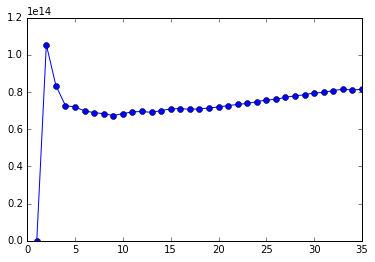

In [20]:

import matplotlib.pyplot as plt
%matplotlib inline
kvals = range(1,36)
plt.plot(kvals, rss_all,'bo-')
print rss_all.argsort()

# curve flatens out after k = 3 . Rss value on test set for k = 3 

In [111]:
rss_test = knnp1(features_train, features_valid[0:1740],3,output_train,output_test)

In [112]:
rss_test

353957570304403.56

*****end*****